# Intro
## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms import Compose, ToTensor, Lambda, Normalize
import torchvision
import torch.optim as optim
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from torch.utils.data import random_split, Subset, DataLoader, TensorDataset
from collections import Counter
from tqdm import tqdm
import random

In [2]:
#Setting the seed as the same in prev projects.
seed = 265
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
torch.manual_seed(seed)
torch.set_default_dtype(torch.float32)


In [4]:
#The standard dataset
localization_train = torch.load('data\localization_train.pt')
localization_val = torch.load('data\localization_val.pt')
localization_test = torch.load('data\localization_test.pt')


Size of training set: 59400
Size of validation set: 6600
Size of test set: 11000

Image size: torch.Size([1, 48, 60])

Amount of train images with an object: 54000
Amount of train images with no objects: 5400

Label distribution: 0: 5345 1: 6075 2: 5365 3: 5522 4: 5243 5: 4889 6: 5310 7: 5644 8: 5249 9: 5358

The first image


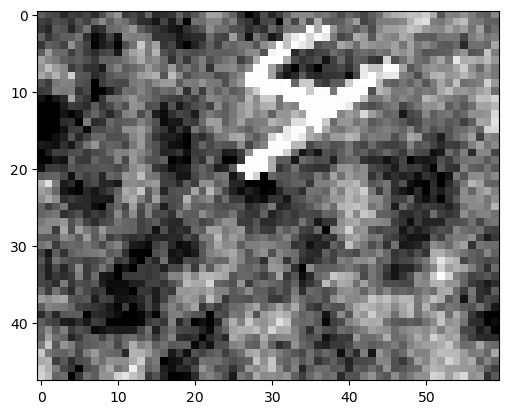

In [403]:
#Printing some general information about the datasets.
print(f'Size of training set: {len(localization_train)}')
print(f'Size of validation set: {len(localization_val)}')
print(f'Size of test set: {len(localization_test)}')
print()

print(f'Image size: {localization_train[:][0][0].shape}')
print()

train_labels_objects_only = localization_train[:][1][localization_train[:][1][:,0] == 1]

print(f'Amount of train images with an object: {len(train_labels_objects_only)}')
print(f'Amount of train images with no objects: {len(localization_train) - len(train_labels_objects_only)}')
print()

vals, counts = torch.unique(train_labels_objects_only[:,-1], return_counts=True)

print("Label distribution: " + " ".join([f'{int(val)}: {count}' for val, count in zip(vals, counts)]))

print('\nThe first image')
plt.imshow(localization_train[0][0].permute(1,2,0), cmap='gray')

The distribution is fairly balanced, and the size of the training set sufficient. Would not be necessary to downsample certain classes nor upsample. Could perhaps use some artificial upsampling to create more training points 

## Showcase function

In [317]:
#A function that draws bounding boxes on an image. Takes data and label
def draw_bounding(data_point, pred_box = None):
    
    #Changing the format of the image to work with draw_bounding_boxes function from torchvisions
    img = torch.floor(255*data_point[0].clone()).type(torch.uint8)

    #If the image does not have an object, then set the bounding box to 0,0,0,0. 
    #Could just return the image, but we want to see if the the predicted is something.
    if data_point[1][0] != 0:
        box = data_point[1][1:5].clone()
    else:
        box = torch.tensor([0,0,0,0])

    #Add the predicted box to boxes
    if pred_box != None:
        boxes = [box, F.relu(pred_box)]
    else:
        boxes = [box]

    #Convert the boxes to the format draw_bounding_boxes accepts with rescaling and box_convert function. To change from cxcywh to min_xy, max_xy
    for i in range(0, len(boxes)):
    
        boxes[i][::2] = boxes[i][::2]*60
        boxes[i][1::2] = boxes[i][1::2]*48
        
        boxes[i] = torch.floor(torchvision.ops.box_convert(boxes=boxes[i], in_fmt='cxcywh', out_fmt= 'xyxy')).type(torch.int).tolist()

    #Converting the list to a tensor.
    boxes = torch.tensor(boxes, dtype=torch.int).reshape(len(boxes),4)
    
    #Drawing the bounding boxes
    img_b = draw_bounding_boxes(img, boxes, width=1,
                                fill=True, 
                                colors=[("red"), 'blue']
                                )
    
    #Returning the image
    return img_b

In [318]:
#Shows the bounding box
def show_bounding(data_point, pred_box=None):
    img_b = draw_bounding(data_point, pred_box=pred_box)
    plt.imshow(img_b.permute(1,2,0))


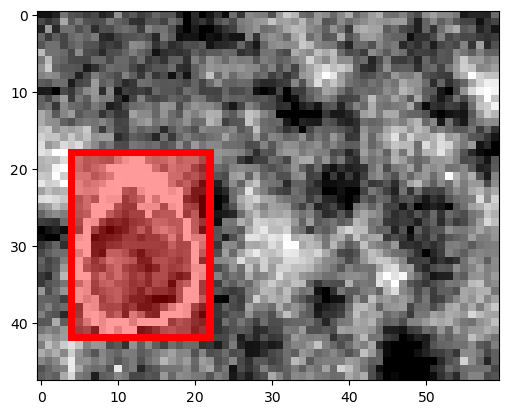

In [319]:
show_bounding(localization_train[1])

In [378]:
#Uses draw_boinding box to showcase multiple images with boundingbox, predictions, and relevant information
def show_examples(example, n, pred_boxes = None, pred_pc = None, pred_class=None):
    _, axes = plt.subplots(nrows=int(n/5), ncols=5, figsize=(10,n/2.5))

    #Making sure that it is possible to show without predictions
    if pred_boxes == None:
        pred_boxes = [None for i in axes.flat]
    
    #Handle if relevant pred info is not present
    if pred_pc == None:
        pred_pc = ['' for x in range(0,n)]
    else:
        pred_pc = [f'{x :.2f}' for x in pred_pc]

    if pred_class == None:
        pred_class = ['' for x in range(0,n)]
    else:
        pred_class = [f'{x}' for x in pred_class]
    
    
    #For every ax in the subplots. Draw the bounding box, and display it with specified information.
    for i, ax in enumerate(axes.flat):
        img = draw_bounding(example[i], pred_box=pred_boxes[i])


        
        ax.imshow(img.permute(1,2,0), cmap='gray')

        if example[i][1][0] == 0:
            label = 'empty'
        else:
            label = example[i][1][5].item()

        ax.set_title(f'True: {label} | Pred: {pred_class[i]} , pc: {pred_pc[i]}', fontsize=7)
        
        ax.axis('off')


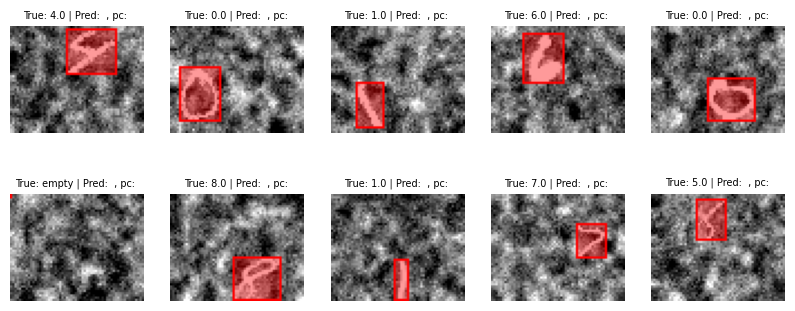

In [399]:
#Testing the function
show_examples(localization_train,10)

## Preprocess

In [404]:
#Finding mean and std of the training set
train_mean, train_std = localization_train[:][0].mean(dim=(0,2,3)), localization_train[:][0].std(dim=(0,2,3))

In [405]:
#Normalizing 
localization_train_t_data = (localization_train[:][0].clone() - train_mean) / train_std
localization_val_t_data = (localization_val[:][0].clone() - train_mean) / train_std
localization_test_t_data = (localization_test[:][0].clone() - train_mean) / train_std

In [406]:
#Using the normalized data with labels to create a normalized dataset
localization_train_t = TensorDataset(localization_train_t_data, localization_train[:][1])
localization_val_t = TensorDataset(localization_val_t_data, localization_val[:][1])
localization_test_t = TensorDataset(localization_test_t_data, localization_test[:][1])

In [409]:
#Sanity check to see if the data is correctly normalized
localization_train_t_data.mean(dim=(0,2,3)), localization_train_t_data.std(dim=(0,2,3))

(tensor([-5.7496e-08]), tensor([1.]))

In [333]:
#Outputting some values to see how the image looks
localization_train_t[0]

(tensor([[[-0.2448, -0.5763, -0.6574,  ..., -0.1098, -0.2304,  0.5260],
          [-0.7759, -0.9111, -0.5179,  ...,  0.2532, -0.1359, -0.1837],
          [-0.9300, -1.2272, -0.2816,  ...,  0.9678, -0.3542,  0.0858],
          ...,
          [ 1.1815,  1.3042, -0.8113,  ..., -0.2058,  0.4911, -0.0716],
          [ 1.7947,  1.2214,  0.3495,  ...,  0.4873, -0.2543, -0.7809],
          [ 1.8919,  1.4605, -0.1094,  ...,  0.8972, -1.0338, -0.3012]]]),
 tensor([1.0000, 0.6000, 0.2292, 0.3667, 0.4167, 4.0000]))

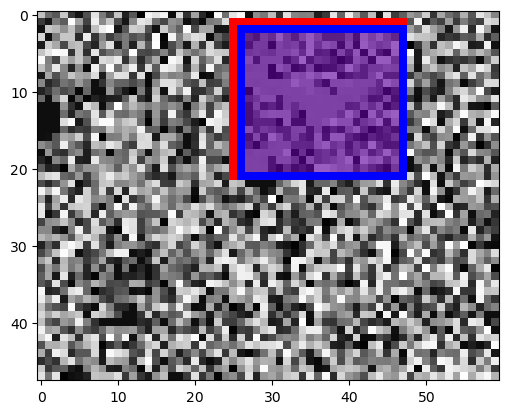

In [335]:
#Showing it with the show_bounding function and a hand picked prediction.
show_bounding(localization_train_t[0], pred_box = torch.tensor([0.61, 0.25, 0.35, 0.4], dtype=torch.float32))

## Training some CNNs

### Networks

In [23]:
#Shallow convolutional layer, with shallow fully connected
class CNN1(nn.Module):
    
    #Architecture
    def __init__(self, in_channels = 1, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.fc1 = nn.Linear(16*12*15, 5+num_classes)
    
    #Forward pass
    def forward(self, x):
        
        #Conv layers
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        #Fully con layers
        x.shape
        x = x.flatten(start_dim=1)
        x = self.fc1(x)

        #Splitting the output
        obj, bbox, classes = torch.tensor_split(x, (1,5), dim=1)
        
        return obj, bbox, classes

In [24]:
#Shallow convolution with deeper fully connected
class CNN2(nn.Module):
    
    #Architecture
    def __init__(self, in_channels = 1, num_classes=10):
        super().__init__()
        
        #Block 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(5,5), stride=(1,1), padding=(2,2))
        self.bn1 = nn.BatchNorm2d(3)
        
        #Pooling
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        
        #Block2
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=(5,5), stride=(1,1), padding=(1,1))
        self.bn2 = nn.BatchNorm2d(10)

        

        self.fc1 = nn.Linear(10*11*14, 1000)
        self.fc2 = nn.Linear(1000, 320)
        self.fc3 = nn.Linear(320, 5+num_classes)
    
    #Forward pass
    def forward(self, x):
        
        #same dim x 3 channels
        x = F.relu(self.conv1(x))
        
        
        x = self.pool(x) # -> #24x30x3
        x = F.relu(self.conv2(x)) # -> #22x28x10
        x = self.pool(x) #-> 11x14x10

        #Fully connected
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)


        obj, bbox, classes = torch.tensor_split(x, (1,5), dim=1)
        
        return obj, bbox, classes

In [25]:
#Shallow convolution with deeper fully connected
class CNN2_bn(nn.Module):
    
    #Architecture
    def __init__(self, in_channels = 1, num_classes=10):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(5,5), stride=(1,1), padding=(2,2))
        self.bn1 = nn.BatchNorm2d(3)
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        #30x24 -> 28x22
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=(5,5), stride=(1,1), padding=(1,1))
        self.bn2 = nn.BatchNorm2d(10)

        

        self.fc1 = nn.Linear(10*11*14, 1000)
        self.fc2 = nn.Linear(1000, 320)
        self.fc3 = nn.Linear(320, 5+num_classes)
    
    #Forward pass
    def forward(self, x):
        
        x = F.relu(self.bn1(self.conv1(x)))

        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)


        obj, bbox, classes = torch.tensor_split(x, (1,5), dim=1)
        
        return obj, bbox, classes

In [26]:
#Deeper convolution, with deeper fully connected
class CNN3(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, (3, 3), stride=1, padding=1)
        self.max_pool1 = nn.MaxPool2d((2, 2), stride=2) # -> 24x30x32

        self.conv3 = nn.Conv2d(32, 64, (3, 3), stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, (3, 3), stride=1, padding=1)
        self.max_pool2 = nn.MaxPool2d((2, 2), stride=2) # -> 12x15x64

        self.conv5 = nn.Conv2d(64, 32, (3, 3), stride=1, padding=1)
        self.conv6 = nn.Conv2d(32, 16, (3, 4), stride=1, padding=0) # -> 10x12x16
        self.max_pool3 = nn.MaxPool2d((2, 2), stride=2) # -> 5x6x16

        self.fc1 = nn.Linear(5*6*16, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 5+num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.max_pool1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.max_pool2(x)

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.max_pool3(x)

        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        obj, bbox, classes = torch.tensor_split(x, (1, 5), dim=1)

        return obj, bbox, classes 

In [27]:
#Deeper convolution with batchnorm.
class CNN3_bn(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.batchnorm16 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, (3, 3), stride=1, padding=1)
        self.batchnorm32 = nn.BatchNorm2d(32)
        self.max_pool1 = nn.MaxPool2d((2, 2), stride=2) # -> 24x30x32
        self.conv3 = nn.Conv2d(32, 64, (3, 3), stride=1, padding=1)
        self.batchnorm64 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, (3, 3), stride=1, padding=1)
        self.max_pool2 = nn.MaxPool2d((2, 2), stride=2) # -> 12x15x64
        self.conv5 = nn.Conv2d(64, 32, (3, 3), stride=1, padding=1)
        self.conv6 = nn.Conv2d(32, 16, (3, 4), stride=1, padding=0) # -> 10x12x16
        self.max_pool3 = nn.MaxPool2d((2, 2), stride=2) # -> 5x6x16
        self.fc1 = nn.Linear(5*6*16, 100)
        self.fc2 = nn.Linear(100, 5+num_classes)

    def forward(self, x):
        x = F.relu(self.batchnorm16(self.conv1(x)))
        x = F.relu(self.batchnorm32(self.conv2(x)))
        x = self.max_pool1(x)

        x = F.relu(self.batchnorm64(self.conv3(x)))
        x = F.relu(self.batchnorm64(self.conv4(x)))
        x = self.max_pool2(x)

        x = F.relu(self.batchnorm32(self.conv5(x)))
        x = F.relu(self.batchnorm16(self.conv6(x)))
        x = self.max_pool3(x)

        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        obj, bbox, classes = torch.tensor_split(x, (1, 5), dim=1)

        return obj, bbox, classes 


In [28]:
#CNN4 with more filters.
class CNN4(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.batchnorm16 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 64, (3, 3), stride=1, padding=1)
        self.batchnorm32 = nn.BatchNorm2d(32)
        self.max_pool1 = nn.MaxPool2d((2, 2), stride=2) # -> 24x30x32
        self.conv3 = nn.Conv2d(64, 64, (3, 3), stride=1, padding=1)
        self.batchnorm64 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, (3, 3), stride=1, padding=1)
        self.batchnorm128 = nn.BatchNorm2d(128)
        self.max_pool2 = nn.MaxPool2d((2, 2), stride=2) # -> 12x15x64
        self.conv5 = nn.Conv2d(128, 64, (3, 3), stride=1, padding=1)
        self.conv6 = nn.Conv2d(64, 32, (3, 4), stride=1, padding=0) # -> 10x12x16
        self.max_pool3 = nn.MaxPool2d((2, 2), stride=2) # -> 5x6x16
        self.fc1 = nn.Linear(5*6*32, 200)
        self.fc2 = nn.Linear(200, 5+num_classes)

    def forward(self, x):
        x = F.relu(self.batchnorm16(self.conv1(x)))
        x = F.relu(self.batchnorm64(self.conv2(x)))
        x = self.max_pool1(x)

        x = F.relu(self.batchnorm64(self.conv3(x)))
        x = F.relu(self.batchnorm128(self.conv4(x)))
        x = self.max_pool2(x)

        x = F.relu(self.batchnorm64(self.conv5(x)))
        x = F.relu(self.batchnorm32(self.conv6(x)))
        x = self.max_pool3(x)

        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        obj, bbox, classes = torch.tensor_split(x, (1, 5), dim=1)

        return obj, bbox, classes 


#### Resnet attempts

Used material from:
- Code adapted from: Aladdin Persson. (2020, April 13). Pytorch ResNet implementation from Scratch [Video]. YouTube. https://www.youtube.com/watch?v=DkNIBBBvcPs
- Andrew Ng's videos were also helpfull.
- https://www.youtube.com/watch?v=ZILIbUvp5lk
- https://www.youtube.com/watch?v=RYth6EbBUqM

In [410]:
class block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(block, self).__init__()
        #How many channels will be expanded after the block 
        self.expansion = 4

        #Bottleneck1 with normalization
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

        #
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)

        #Bottleneck2 with normalization
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=stride, padding=0)

        #Activation function and downsample to keep shape in later layers.
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x

        x = self.conv1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        
        x = self.conv3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        
        x+= identity
        x = self.relu(x)
        return x

In [411]:
class block_norm(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(block_norm, self).__init__()
        #How many channels will be expanded after the block 
        self.expansion = 4

        #Bottleneck1 with normalization
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)

        #Larger kernel
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        #Bottleneck2 with normalization
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)

        #Activation function and downsample to keep shape in later layers.
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
    

    def forward(self, x):

        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)


        if self.identity_downsample is not None:
            #print(identity.shape)
            identity = self.identity_downsample(identity)
            #print(identity.shape)
        
        #print(x.shape, identity.shape)
        x += identity
        x = self.relu(x)
        return x
    


In [412]:
#Layers: how many times to reuse the block
class ResNet(nn.Module):
    def __init__(self, block, layers: list, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=5, stride=2, padding=3) #24x32x64
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) #12x16x64

        #Resnet layers
        self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(512*4, 500)
        self.fc2 = nn.Linear(500, 5+num_classes)
    
    def forward(self, x):

        #Convolution
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        #Resnet blocks
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        #Correct shape
        x = self.avgpool(x)
    
        #Fully connected
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        obj, bbox, classes = torch.tensor_split(x, (1,5), dim=1)
        return obj, bbox, classes
    



    def _make_layer(self, block, num_risidual_blocks, out_channels, stride):
        identity_downsample = None
        layers = []

        #When to change the identity of the conv layer
        if stride != 1 or self.in_channels != out_channels*4:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels*4, kernel_size=1, stride=stride), nn.BatchNorm2d(out_channels*4))
        
        #Changes the number of channels
        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))

        #Therefore we need to change the number of in_channels
        self.in_channels = out_channels*4

        #Already computed one risidual block
        #Intermidiate Conv layers
        for i in range(num_risidual_blocks - 1):
            layers.append(block(self.in_channels, out_channels)) # in_channels -> out_channels -> out_channels*4
        
        #Unpack the list into a sequential layer.
        return nn.Sequential(*layers)



In [413]:
#A bit overkill
def ResNet50(img_channels=1, num_classes=10):
    return ResNet(block_norm, [3,4,6,3], img_channels, num_classes) # 3,4,6,3

In [414]:
#Hypothesis is that since the image is smaller than what resnet50 are normally used for. Then more blocks in the early network are good for receptive field. 
def customResNet(img_channels=1, num_classes=10):
    return ResNet(block_norm, [8,6,3,1], img_channels, num_classes)

In [416]:
#Some small tests to see that the networks work
model = CNN1().to(device)

In [417]:
localization_train[0][0].unsqueeze(0).shape

torch.Size([1, 1, 48, 60])

In [418]:
test_case = localization_train[3:6]
test_data = test_case[0].to(device)
true_label = test_case[1].to(device)

In [419]:
pred = model(test_data.to(device))
pc, bound_box, pred_class = pred

In [424]:
Pc_true, bound_box_true, true_class = torch.tensor_split(true_label, (1,5), dim=1)

In [425]:
Pc_true, bound_box_true, true_class

(tensor([[1.],
         [1.],
         [0.]], device='cuda:0'),
 tensor([[ 0.3917,  0.2917,  0.2833,  0.4583],
         [ 0.5917,  0.6771,  0.3500,  0.3958],
         [-1.0000, -1.0000, -1.0000, -1.0000]], device='cuda:0'),
 tensor([[6.],
         [0.],
         [1.]], device='cuda:0'))

### Loss functions
L = L1 + L2 + L3

In [41]:
#Creating a custom_loss with regular python function
def custom_loss(input, true_output):
    
    #Splitting the predictions and targets
    pc, bound_box, pred_class = input
    pc_true, bound_box_true, true_class = torch.tensor_split(true_output.to(device), (1,5), dim=1)

    #Computing BCE with logits loss
    pc_loss = nn.BCEWithLogitsLoss() (pc, pc_true) #CrossEntropyLoss, MSELoss
    
    #Getting a mask for when pc_true is larger than 0.5. It is either 0 or 1. 
    pc_true_ind = (pc_true > 0.5).squeeze(1)
    
    #Using this as a mask to only compute bbox loss where there is indeed an object.
    bbox_loss = nn.MSELoss() (bound_box[pc_true_ind], bound_box_true[pc_true_ind]) 
    
    #Using the mask to compute class loss
    class_loss = nn.CrossEntropyLoss() (pred_class[pc_true_ind], true_class[pc_true_ind].squeeze(1).type(torch.long))

    loss = pc_loss + bbox_loss + class_loss 
    return loss

### Testing

### Performance measure

In [44]:
testing_bb = torch.tensor_split(localization_train[0:4][1], (1,5), dim=1)
testing_bb = testing_bb[1]
testing_bb

tensor([[0.6000, 0.2292, 0.3667, 0.4167],
        [0.2167, 0.6250, 0.3000, 0.5000],
        [0.2833, 0.7292, 0.2000, 0.4167],
        [0.3917, 0.2917, 0.2833, 0.4583]])

In [45]:
def compute_intersection(box1, box2):
    
    x1, y1, w1, h1 = box1[:,0], box1[:,1], box1[:,2], box1[:,3]
    x2, y2, w2, h2 = box2[:,0], box2[:,1], box2[:,2], box2[:,3]

    #print(x1,y1, w1, h1)
    #print(box1)

    x_inter = torch.max(x1, x2)
    y_inter = torch.max(y1, y2)
    w_inter = torch.min(x1 + w1, x2 + w2) - x_inter
    h_inter = torch.min(y1 + h1, y2 + h2) - y_inter

    
    w_inter[w_inter <= 0] = 0
    h_inter[h_inter <= 0] = 0
    
    return torch.mul(w_inter, h_inter)

In [46]:
def compute_union_area(box1, box2, intersection_area):
    x1, y1, w1, h1 = box1[:,0], box1[:,1], box1[:,2], box1[:,3]
    x2, y2, w2, h2 = box2[:,0], box2[:,1], box2[:,2], box2[:,3]

    area_box1 = w1 * h1
    area_box2 = w2 * h2

    return area_box1 + area_box2 - intersection_area

In [47]:
def compute_iuo(box1, box2):
    
    x1, y1, w1, h1 = box1[:,0], box1[:,1], box1[:,2], box1[:,3]
    x2, y2, w2, h2 = box2[:,0], box2[:,1], box2[:,2], box2[:,3]

    #print(x1,y1, w1, h1)
    #print(box1)

    x_inter = torch.max(x1, x2)
    y_inter = torch.max(y1, y2)
    w_inter = torch.min(x1 + w1, x2 + w2) - x_inter
    h_inter = torch.min(y1 + h1, y2 + h2) - y_inter

    
    w_inter[w_inter <= 0] = 0
    h_inter[h_inter <= 0] = 0
    
    intersection_area = torch.mul(w_inter, h_inter)
    area_box1 = w1 * h1
    area_box2 = w2 * h2

    return intersection_area/(area_box1 + area_box2 - intersection_area)

In [48]:
#Sanity check with same input and output
compute_iuo(testing_bb, testing_bb)

tensor([1.0000, 1.0000, 1.0000, 1.0000])

In [49]:
compute_iuo(torch.tensor([[0,0,0,0], [0.1,0.3,0.4,0.3]]), torch.tensor([[1,1,1,1], [0.5,0.5,0.1,0.1]]))

tensor([0., 0.])

In [50]:
#This version uses .max, since the true targets dont have 15 channels, but 6. This function is for sanity checks.
def performance_measuring(predictions, true_targets, i=1):
        
    #Take the sigmoid of the first index of output
    sig = nn.Sigmoid()
    pc = sig(predictions[0]).squeeze(1)

    #The index of what datapoints the model are confident contains an object. Only these cases are necessary for bbox and class.
    pc_ind = [pc > 0.5]
    
    #Map the pc to either 0 or 1, with treshold.
    pc[pc_ind] = 1
    pc[pc <= 0.5] = 0
    
    #Calculate pc accuracy with targets
    pc_ac = pc == true_targets[:,0]
    
    #Calculate class accuracy with target classes
    c_ac = torch.nan_to_num(predictions[2][pc_ind].max(dim=1)[i]  == true_targets[:,5][pc_ind])

    #Calculate iou
    iou = torch.nan_to_num(compute_iuo(predictions[1], true_targets[:,1:5]))

    #Only return the IoU for the points are confident in having an image. 
    performance = torch.tensor([pc_ac.count_nonzero()/ len(pc_ac), iou[pc_ind].mean(), c_ac.count_nonzero()/len(c_ac)])



    return performance

In [51]:
#Sanity check to see if true_labels gives 1,1,1
pred = torch.tensor_split(localization_train[:100][1], (1,5), dim=1)
performance_measuring(pred, localization_train[:100][1], i=0)

tensor([1., 1., 1.])

In [52]:
#Sanity check of an empty image and an image with an object
pred = torch.tensor_split(localization_train[0:1][1], (1,5), dim=1)
performance_measuring(pred, localization_train[5:6][1], i=0)

tensor([0., 0., 0.])

In [53]:
localization_train[:14][1]
#Can see that 0, and 12 have same label

tensor([[ 1.0000,  0.6000,  0.2292,  0.3667,  0.4167,  4.0000],
        [ 1.0000,  0.2167,  0.6250,  0.3000,  0.5000,  0.0000],
        [ 1.0000,  0.2833,  0.7292,  0.2000,  0.4167,  1.0000],
        [ 1.0000,  0.3917,  0.2917,  0.2833,  0.4583,  6.0000],
        [ 1.0000,  0.5917,  0.6771,  0.3500,  0.3958,  0.0000],
        [ 0.0000, -1.0000, -1.0000, -1.0000, -1.0000,  1.0000],
        [ 1.0000,  0.6417,  0.7812,  0.3500,  0.3958,  8.0000],
        [ 1.0000,  0.5250,  0.7917,  0.0833,  0.3750,  1.0000],
        [ 1.0000,  0.7417,  0.4271,  0.2167,  0.3125,  7.0000],
        [ 1.0000,  0.4417,  0.2292,  0.2167,  0.3750,  5.0000],
        [ 1.0000,  0.5833,  0.1979,  0.1667,  0.3125,  0.0000],
        [ 0.0000, -1.0000, -1.0000, -1.0000, -1.0000,  1.0000],
        [ 1.0000,  0.2333,  0.4792,  0.2000,  0.4167,  4.0000],
        [ 1.0000,  0.2833,  0.4271,  0.4667,  0.4792,  2.0000]])

In [54]:
#Sanity check of empty image and image with object
pred = torch.tensor_split(localization_train[0:1][1], (1,5), dim=1)
performance_measuring(pred, localization_train[12:13][1], i=0)

tensor([1., 0., 1.])

In [55]:
#Sanity with hand calculated data points
pred = torch.tensor_split(localization_train[0:3][1], (1,5), dim=1)
performance_measuring(pred, localization_train[3:6][1], i=0)

tensor([0.6667, 0.0346, 0.6667])

In [57]:
#Takes predictions and targets and outputs the accuracy and iou
def performance_measuring(predictions, true_targets, i=1):
    #Important since we dont need gradients for the performance measure. Without we get memory leak if we add gradient for every tensor.
    #In the validation this would be unnecessary. But since this function is not meant to calculate gradients. It is better to include it in the function.
    #Therefore it would not be necessary to call the function with a wrapper, but optional. 
    with torch.no_grad():
        
        #Take the sigmoid of the first index of output
        sig = nn.Sigmoid()
        pc = sig(predictions[0]).squeeze(1)

        #The index of what datapoints the model are confident contains an object. Only these cases are necessary for bbox and class.
        pc_ind = [pc > 0.5]
        
        #Map the pc to either 0 or 1, with treshold.
        pc[pc_ind] = 1
        pc[pc <= 0.5] = 0
        
        #Calculate pc accuracy with targets
        pc_ac = pc == true_targets[:,0]
        
        #Calculate class accuracy with target classes
        c_ac = torch.nan_to_num(predictions[2][pc_ind].argmax(dim=1)  == true_targets[:,5][pc_ind])

        #Calculate iou
        iou = torch.nan_to_num(compute_iuo(predictions[1], true_targets[:,1:5]))

        #Only return the IoU for the points are confident in having an image. 
        performance = torch.tensor([pc_ac.count_nonzero()/ len(pc_ac), iou[pc_ind].mean(), c_ac.count_nonzero()/len(c_ac)])



    return performance


### Training loop

In [58]:
#Modified code from 1st tutorial. Dont think that it is necessary to change too much. 

def train(n_epochs, optimizer, model, train_loader, val_loader):

    #Get number of batches, make a list for training losses, change model mode to training, and zero the gradients.
    n_batch = len(train_loader)
    losses_train = []
    losses_val = []
    performance_train = []
    performance_val = []
    

    optimizer.zero_grad(set_to_none=True)
    model.train()
    
    #Every epoch compute gradients of the parameters and update them
    for epoch in range(1, n_epochs + 1):
        #Progress bar
        train_progressbar = tqdm(total=len(train_loader), desc=f"Epoch: {epoch}")
        
        #Store the total loss for the epoch
        loss_train = 0.0
        train_perf = torch.tensor([0,0,0], dtype=torch.float32)

        loss_val = 0.0
        val_perf = torch.tensor([0,0,0], dtype=torch.float32)
        
        
        model.train()
        
        #For every batch in the loader 
        for imgs, labels in train_loader:

            #Send the data to the same device
            imgs = imgs.to(device=device, dtype=torch.float32) 
            labels = labels.to(device=device, dtype=torch.float32)

            #Compute the inference of the images
            outputs = model(imgs)
            
            
            
            #Compare the loss between inference and true labels
            loss = custom_loss(outputs, labels)
            
            #Find the gradients of loss with repsect to gradients # Potentially add .sum()
            loss.sum().backward()
            
            #Update the parameters
            optimizer.step()
            
            #Zero the grad
            optimizer.zero_grad()

            #Add the loss a
            loss_train += loss.sum().item()

            performance = performance_measuring(outputs, labels)
                        
            train_perf += performance

            train_progressbar.update()
        
        model.eval()
        for imgs, labels in val_loader:
                    with torch.no_grad():

                        #Send the data to the same device
                        imgs = imgs.to(device=device, dtype=torch.float32) 
                        labels = labels.to(device=device, dtype=torch.float32)

                        #Compute the inference of the images
                        outputs = model(imgs)
                        loss = custom_loss(outputs, labels)
                        performance = performance_measuring(outputs, labels)

                        loss_val += loss.sum().item()
                        val_perf += performance
            
            
            

        
        
        #Add the loss of the epoch to the list
        the_loss = loss_train / n_batch
        losses_train.append(the_loss)
        losses_val.append(loss_val / len(val_loader))
        performance_train.append(train_perf / n_batch)
        performance_val.append(val_perf / len(val_loader))
        
        train_progressbar.set_description(f"Epoch: {epoch}, Train loss: {the_loss : .3f}, Train Performance: {train_perf / n_batch}")
        train_progressbar.close()
        
        

    return losses_train, losses_val, performance_train, performance_val

### Training on a model

In [385]:
torch.manual_seed(seed)
model = CNN2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
train_loader = DataLoader(localization_train_t, batch_size=256, shuffle=False)
val_loader = DataLoader(localization_val_t, 512)

results = train(50, optimizer, model, train_loader, val_loader)

Epoch: 1:   0%|          | 0/233 [00:00<?, ?it/s]

Epoch: 1, Train loss:  2.563, Train Performance: tensor([0.9089, 0.2331, 0.1667]): 100%|██████████| 233/233 [00:01<00:00, 154.88it/s]
Epoch: 2, Train loss:  2.258, Train Performance: tensor([0.9586, 0.3878, 0.2293]): 100%|██████████| 233/233 [00:01<00:00, 166.89it/s]
Epoch: 3, Train loss:  2.064, Train Performance: tensor([0.9833, 0.4488, 0.2400]): 100%|██████████| 233/233 [00:01<00:00, 171.20it/s]
Epoch: 4, Train loss:  1.942, Train Performance: tensor([0.9881, 0.4852, 0.2931]): 100%|██████████| 233/233 [00:01<00:00, 173.65it/s]
Epoch: 5, Train loss:  1.747, Train Performance: tensor([0.9916, 0.4620, 0.3804]): 100%|██████████| 233/233 [00:01<00:00, 176.50it/s]
Epoch: 6, Train loss:  1.426, Train Performance: tensor([0.9954, 0.4602, 0.5142]): 100%|██████████| 233/233 [00:01<00:00, 155.02it/s]
Epoch: 7, Train loss:  1.190, Train Performance: tensor([0.9958, 0.4765, 0.6043]): 100%|██████████| 233/233 [00:01<00:00, 171.15it/s]
Epoch: 8, Train loss:  1.014, Train Performance: tensor([0.996

### Functions to show model results

In [391]:
#Take an ax and plot graphs
def plot_ax(ax, plots:list, plot_titles:list, title):
    for i in range(len(plots)):
        ax.plot(plots[i], label= plot_titles[i])
        ax.legend()
    ax.set_title(title)


In [392]:
#Plot the results of a models training
def plot_results(results):

    fig, ax = plt.subplots(2,2, sharex=True, figsize=(14,6))


    plot_ax(ax[0,0], [results[0],results[1]], ['Train', 'Val'], 'Loss')
    plot_ax(ax[1,0], [torch.stack(results[2]).mean(dim=1), torch.stack(results[3]).mean(dim=1)], ['Train', 'Val'], 'Performance')
    plot_ax(ax[0,1], [torch.stack(results[2])[:,i] for i in range(0,3)], ['Pc', 'BBox', 'class_ac'], 'Training performance induvidual comp')
    plot_ax(ax[1,1], [torch.stack(results[3])[:,i] for i in range(0,3)], ['Pc', 'BBox', 'class_ac'], 'Validation performance induvidual comp')

    plt.show()

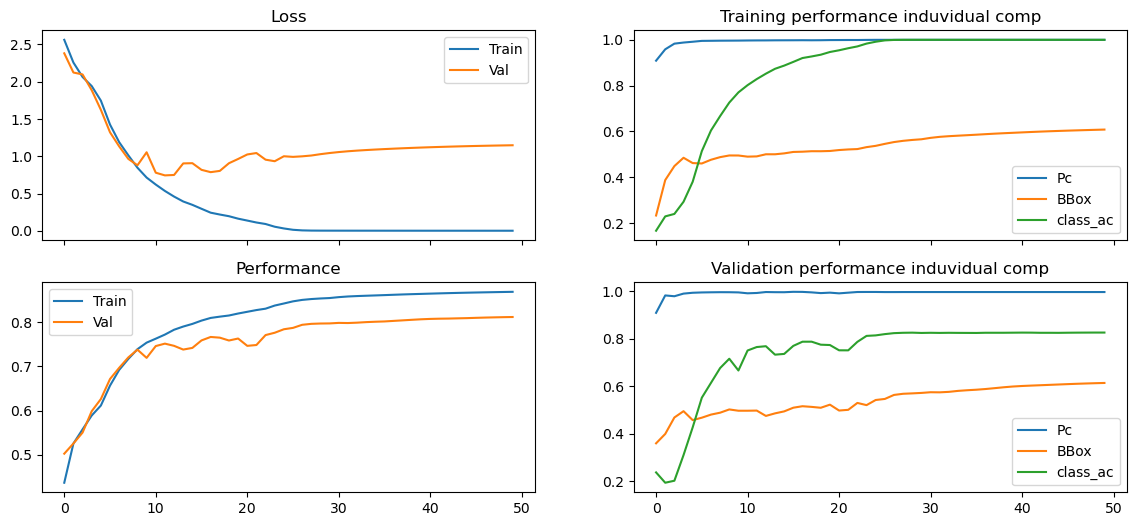

In [393]:
plot_results(results)

In [396]:
#Function to show the true bounding boxes and predicted with relevant information on multiple pictures.
def show_pred_examples(model, data,num_img, show_data=None):
    
    #Looks better with shorter variable
    n = num_img

    #Predict on the data. Get the prediction information and plot it
    with torch.no_grad():
        val_pred = model(data[:n][0].to(device))
        sig = nn.Sigmoid()
        pc, bound_box, pred_class = val_pred #torch.tensor_split(val_pred, (1,5), dim=1)
        
        #If we want to look at the untransformed data instead.
        if show_data is not None:
            show_examples(show_data,n, pred_boxes = bound_box, 
                          pred_pc=sig(pc).squeeze().tolist(),
                          pred_class=pred_class.argmax(dim=1).squeeze().tolist())
        else:
            show_examples(data,n, pred_boxes = bound_box)

        #Print the performance tensor
        perf = performance_measuring(val_pred, data[:n][1].to(device))
        print('Performance:', perf)

Performance: tensor([1.0000, 0.6155, 1.0000])


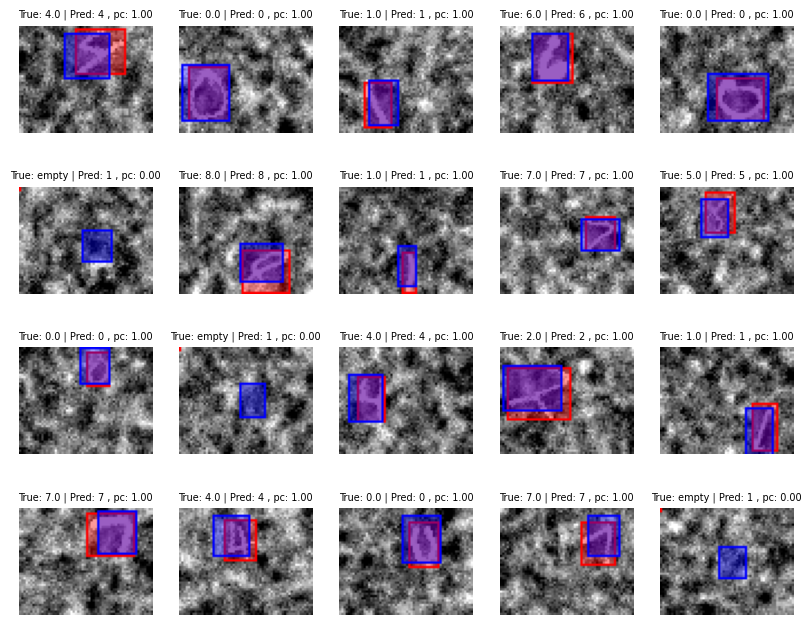

In [398]:
show_pred_examples(model, localization_train_t, 20, show_data=localization_train)

### Model selection and evaluation

In [68]:
#To ensure same weight initialisation

torch.manual_seed(seed)
model1 = CNN1()
torch.manual_seed(seed)
model2 = CNN2()
torch.manual_seed(seed)
model3 = CNN2_bn()
torch.manual_seed(seed)
model4 = CNN3()
torch.manual_seed(seed)
model5 = CNN3_bn()
torch.manual_seed(seed)
model6 = CNN4()
torch.manual_seed(seed)
model7 = customResNet()

In [69]:
#Creating a list for the models and a list for the results. Couldve used dictionary, but I like to convert the list of lists to a stack, and then use indexing. 
models = [model1, model2, model3, model4, model5, model6, model7]
models_results = []

#Dont think this is necessary, but just to ensure same results.
torch.manual_seed(seed)
train_loader = DataLoader(localization_train_t, batch_size=256, shuffle=False)
val_loader = DataLoader(localization_val_t, batch_size=512, shuffle=False)

#For every model. Do the training and append the results.
for model in models:
    torch.manual_seed(seed)
    model_name = type(model).__name__
    print(model_name,'\n')
    
    model = model.to(device)
    optimizer = optim.Adam(model.parameters())
    results = train(20, optimizer, model, train_loader, val_loader)
    models_results.append([model_name, results, model])
    print('\nFinished training\n')


    


CNN1 



Epoch: 1, Train loss:  2.479, Train Performance: tensor([0.9093, 0.2637, 0.2208]): 100%|██████████| 233/233 [00:01<00:00, 160.52it/s]
Epoch: 2, Train loss:  2.073, Train Performance: tensor([0.9697, 0.3953, 0.3073]): 100%|██████████| 233/233 [00:01<00:00, 170.80it/s]
Epoch: 3, Train loss:  1.859, Train Performance: tensor([0.9901, 0.4325, 0.3659]): 100%|██████████| 233/233 [00:01<00:00, 173.91it/s]
Epoch: 4, Train loss:  1.719, Train Performance: tensor([0.9943, 0.4550, 0.4163]): 100%|██████████| 233/233 [00:01<00:00, 173.97it/s]
Epoch: 5, Train loss:  1.618, Train Performance: tensor([0.9958, 0.4654, 0.4564]): 100%|██████████| 233/233 [00:01<00:00, 177.19it/s]
Epoch: 6, Train loss:  1.541, Train Performance: tensor([0.9967, 0.4695, 0.4836]): 100%|██████████| 233/233 [00:01<00:00, 168.36it/s]
Epoch: 7, Train loss:  1.479, Train Performance: tensor([0.9972, 0.4706, 0.5056]): 100%|██████████| 233/233 [00:01<00:00, 172.46it/s]
Epoch: 8, Train loss:  1.426, Train Performance: tensor([0.997


Finished training

CNN2 



Epoch: 1, Train loss:  2.340, Train Performance: tensor([0.9476, 0.3034, 0.1879]): 100%|██████████| 233/233 [00:01<00:00, 177.19it/s]
Epoch: 2, Train loss:  2.071, Train Performance: tensor([0.9846, 0.4215, 0.2393]): 100%|██████████| 233/233 [00:01<00:00, 173.28it/s]
Epoch: 3, Train loss:  1.941, Train Performance: tensor([0.9871, 0.4401, 0.3026]): 100%|██████████| 233/233 [00:01<00:00, 173.52it/s]
Epoch: 4, Train loss:  1.740, Train Performance: tensor([0.9912, 0.4391, 0.3886]): 100%|██████████| 233/233 [00:01<00:00, 174.07it/s]
Epoch: 5, Train loss:  1.488, Train Performance: tensor([0.9948, 0.4477, 0.4883]): 100%|██████████| 233/233 [00:01<00:00, 169.21it/s]
Epoch: 6, Train loss:  1.267, Train Performance: tensor([0.9970, 0.4619, 0.5701]): 100%|██████████| 233/233 [00:01<00:00, 172.34it/s]
Epoch: 7, Train loss:  1.090, Train Performance: tensor([0.9980, 0.4699, 0.6327]): 100%|██████████| 233/233 [00:01<00:00, 174.85it/s]
Epoch: 8, Train loss:  0.951, Train Performance: tensor([0.998


Finished training

CNN2_bn 



Epoch: 1, Train loss:  2.313, Train Performance: tensor([0.9569, 0.3014, 0.1937]): 100%|██████████| 233/233 [00:01<00:00, 139.69it/s]
Epoch: 2, Train loss:  2.058, Train Performance: tensor([0.9859, 0.3732, 0.2414]): 100%|██████████| 233/233 [00:01<00:00, 141.25it/s]
Epoch: 3, Train loss:  1.898, Train Performance: tensor([0.9907, 0.3745, 0.3162]): 100%|██████████| 233/233 [00:01<00:00, 141.87it/s]
Epoch: 4, Train loss:  1.625, Train Performance: tensor([0.9951, 0.3970, 0.4246]): 100%|██████████| 233/233 [00:01<00:00, 136.25it/s]
Epoch: 5, Train loss:  1.380, Train Performance: tensor([0.9968, 0.4134, 0.5216]): 100%|██████████| 233/233 [00:01<00:00, 141.20it/s]
Epoch: 6, Train loss:  1.184, Train Performance: tensor([0.9977, 0.4244, 0.5950]): 100%|██████████| 233/233 [00:01<00:00, 141.17it/s]
Epoch: 7, Train loss:  1.019, Train Performance: tensor([0.9978, 0.4329, 0.6555]): 100%|██████████| 233/233 [00:01<00:00, 140.00it/s]
Epoch: 8, Train loss:  0.878, Train Performance: tensor([0.998


Finished training

CNN3 



Epoch: 1, Train loss:  2.475, Train Performance: tensor([0.9403, 0.1691, 0.1243]): 100%|██████████| 233/233 [00:05<00:00, 41.95it/s]
Epoch: 2, Train loss:  1.988, Train Performance: tensor([0.9986, 0.3021, 0.2677]): 100%|██████████| 233/233 [00:05<00:00, 42.45it/s]
Epoch: 3, Train loss:  1.150, Train Performance: tensor([0.9978, 0.2155, 0.6051]): 100%|██████████| 233/233 [00:05<00:00, 41.02it/s]
Epoch: 4, Train loss:  0.634, Train Performance: tensor([0.9986, 0.3086, 0.7993]): 100%|██████████| 233/233 [00:05<00:00, 42.14it/s]
Epoch: 5, Train loss:  0.460, Train Performance: tensor([0.9989, 0.3635, 0.8569]): 100%|██████████| 233/233 [00:05<00:00, 42.93it/s]
Epoch: 6, Train loss:  0.365, Train Performance: tensor([0.9992, 0.3973, 0.8854]): 100%|██████████| 233/233 [00:05<00:00, 42.77it/s]
Epoch: 7, Train loss:  0.302, Train Performance: tensor([0.9993, 0.4303, 0.9055]): 100%|██████████| 233/233 [00:05<00:00, 42.75it/s]
Epoch: 8, Train loss:  0.262, Train Performance: tensor([0.9996, 0.45


Finished training

CNN3_bn 



Epoch: 1, Train loss:  1.510, Train Performance: tensor([0.9765, 0.2367, 0.5000]): 100%|██████████| 233/233 [00:06<00:00, 35.27it/s]
Epoch: 2, Train loss:  0.404, Train Performance: tensor([0.9991, 0.3476, 0.8799]): 100%|██████████| 233/233 [00:06<00:00, 34.88it/s]
Epoch: 3, Train loss:  0.251, Train Performance: tensor([0.9994, 0.4205, 0.9238]): 100%|██████████| 233/233 [00:06<00:00, 35.16it/s]
Epoch: 4, Train loss:  0.188, Train Performance: tensor([0.9996, 0.4574, 0.9422]): 100%|██████████| 233/233 [00:06<00:00, 35.12it/s]
Epoch: 5, Train loss:  0.146, Train Performance: tensor([0.9997, 0.4802, 0.9545]): 100%|██████████| 233/233 [00:06<00:00, 35.14it/s]
Epoch: 6, Train loss:  0.119, Train Performance: tensor([0.9998, 0.4915, 0.9628]): 100%|██████████| 233/233 [00:06<00:00, 35.08it/s]
Epoch: 7, Train loss:  0.100, Train Performance: tensor([0.9997, 0.4931, 0.9686]): 100%|██████████| 233/233 [00:06<00:00, 34.94it/s]
Epoch: 8, Train loss:  0.082, Train Performance: tensor([0.9998, 0.50


Finished training

CNN4 



Epoch: 1, Train loss:  1.675, Train Performance: tensor([0.9773, 0.2822, 0.4352]): 100%|██████████| 233/233 [00:09<00:00, 23.41it/s]
Epoch: 2, Train loss:  0.415, Train Performance: tensor([0.9985, 0.3692, 0.8766]): 100%|██████████| 233/233 [00:09<00:00, 23.72it/s]
Epoch: 3, Train loss:  0.212, Train Performance: tensor([0.9996, 0.4316, 0.9363]): 100%|██████████| 233/233 [00:09<00:00, 23.71it/s]
Epoch: 4, Train loss:  0.155, Train Performance: tensor([0.9998, 0.4654, 0.9540]): 100%|██████████| 233/233 [00:09<00:00, 23.70it/s]
Epoch: 5, Train loss:  0.116, Train Performance: tensor([0.9998, 0.4836, 0.9656]): 100%|██████████| 233/233 [00:09<00:00, 23.57it/s]
Epoch: 6, Train loss:  0.093, Train Performance: tensor([0.9999, 0.4949, 0.9714]): 100%|██████████| 233/233 [00:09<00:00, 23.65it/s]
Epoch: 7, Train loss:  0.075, Train Performance: tensor([0.9999, 0.4997, 0.9769]): 100%|██████████| 233/233 [00:09<00:00, 23.62it/s]
Epoch: 8, Train loss:  0.063, Train Performance: tensor([0.9999, 0.50


Finished training

ResNet 



Epoch: 1, Train loss:  1.380, Train Performance: tensor([0.9852, 0.2955, 0.5255]): 100%|██████████| 233/233 [00:24<00:00,  9.46it/s]
Epoch: 2, Train loss:  0.431, Train Performance: tensor([0.9988, 0.3792, 0.8701]): 100%|██████████| 233/233 [00:25<00:00,  9.26it/s]
Epoch: 3, Train loss:  0.275, Train Performance: tensor([0.9994, 0.4546, 0.9176]): 100%|██████████| 233/233 [00:24<00:00,  9.53it/s]
Epoch: 4, Train loss:  0.213, Train Performance: tensor([0.9994, 0.4737, 0.9360]): 100%|██████████| 233/233 [00:25<00:00,  9.10it/s]
Epoch: 5, Train loss:  0.173, Train Performance: tensor([0.9993, 0.4833, 0.9496]): 100%|██████████| 233/233 [00:24<00:00,  9.41it/s]
Epoch: 6, Train loss:  0.141, Train Performance: tensor([0.9997, 0.4843, 0.9583]): 100%|██████████| 233/233 [00:24<00:00,  9.54it/s]
Epoch: 7, Train loss:  0.128, Train Performance: tensor([0.9997, 0.4942, 0.9624]): 100%|██████████| 233/233 [00:24<00:00,  9.52it/s]
Epoch: 8, Train loss:  0.113, Train Performance: tensor([0.9997, 0.50


Finished training




-------------------------------------------------------------------------------------------------------------------------------------
CNN1 



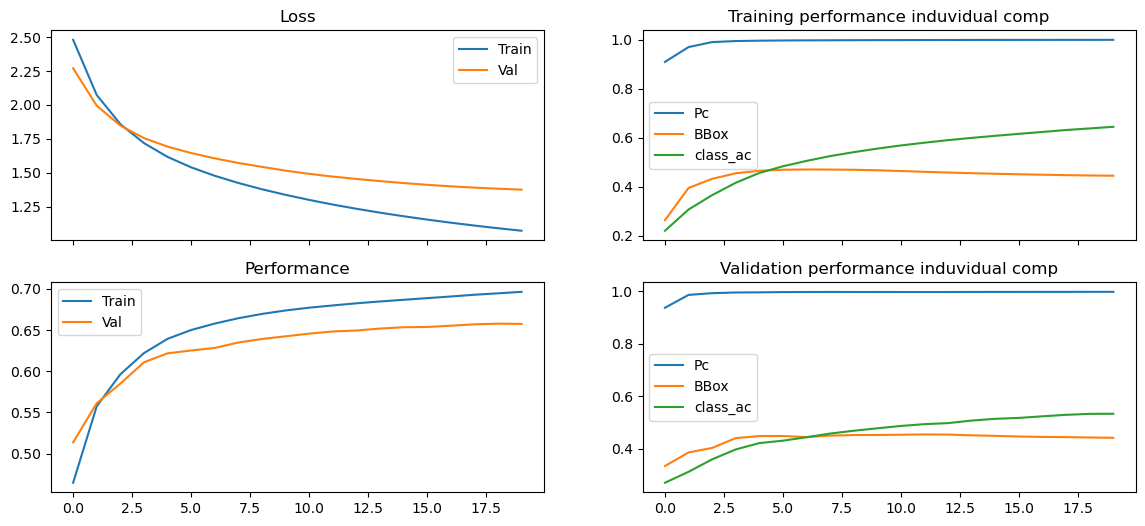

Best epoch for iou: 11 
score: 0.454 

Best epoch for accuracies: 19 
score: 0.765 % 

Best epoch in total: 18 
score: 0.658 

Latest epoch total score: 0.657 

-------------------------------------------------------------------------------------------------------------------------------------


-------------------------------------------------------------------------------------------------------------------------------------
CNN2 



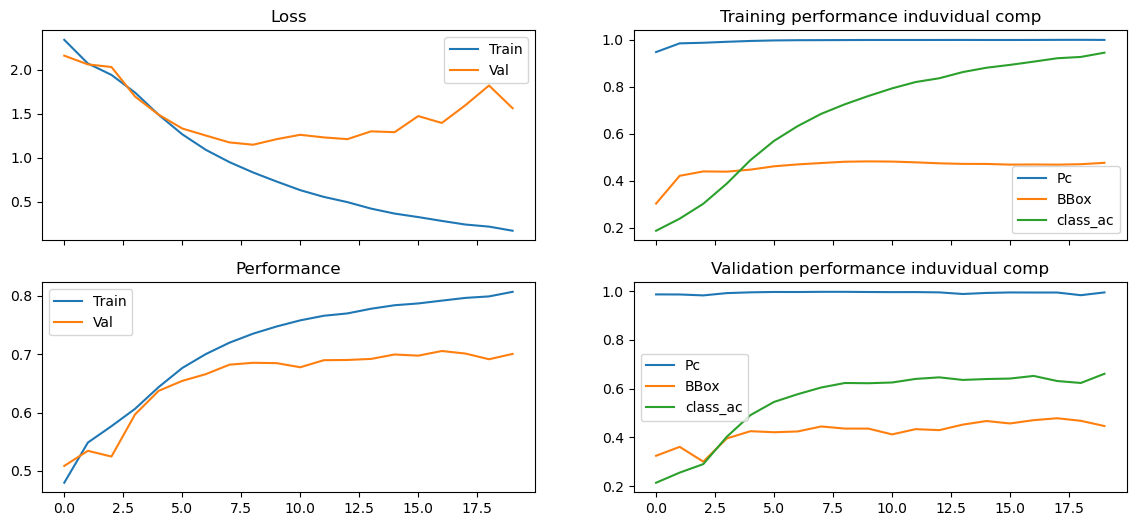

Best epoch for iou: 17 
score: 0.479 

Best epoch for accuracies: 19 
score: 0.827 % 

Best epoch in total: 16 
score: 0.705 

Latest epoch total score: 0.700 

-------------------------------------------------------------------------------------------------------------------------------------


-------------------------------------------------------------------------------------------------------------------------------------
CNN2_bn 



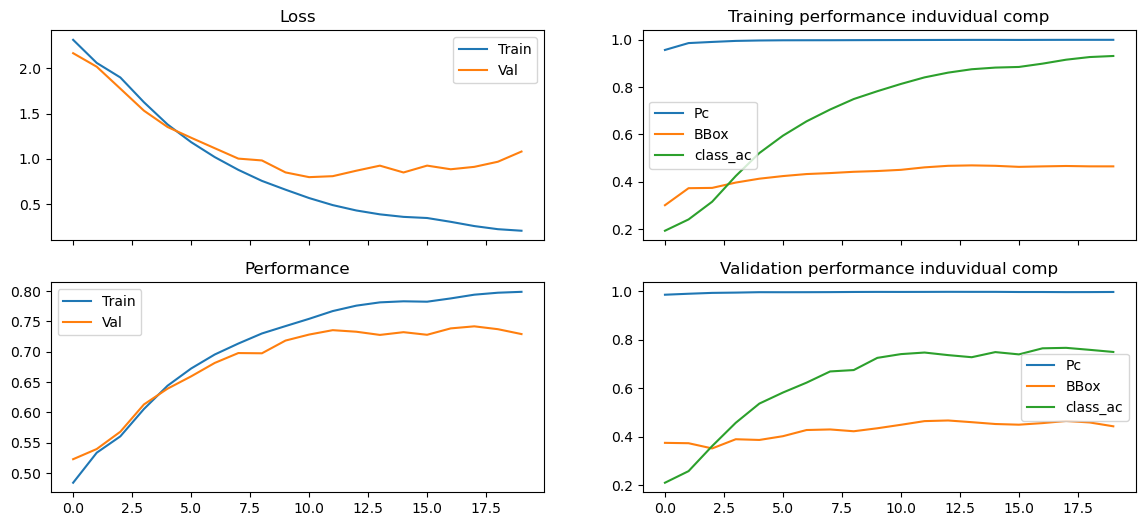

Best epoch for iou: 12 
score: 0.466 

Best epoch for accuracies: 17 
score: 0.881 % 

Best epoch in total: 17 
score: 0.742 

Latest epoch total score: 0.729 

-------------------------------------------------------------------------------------------------------------------------------------


-------------------------------------------------------------------------------------------------------------------------------------
CNN3 



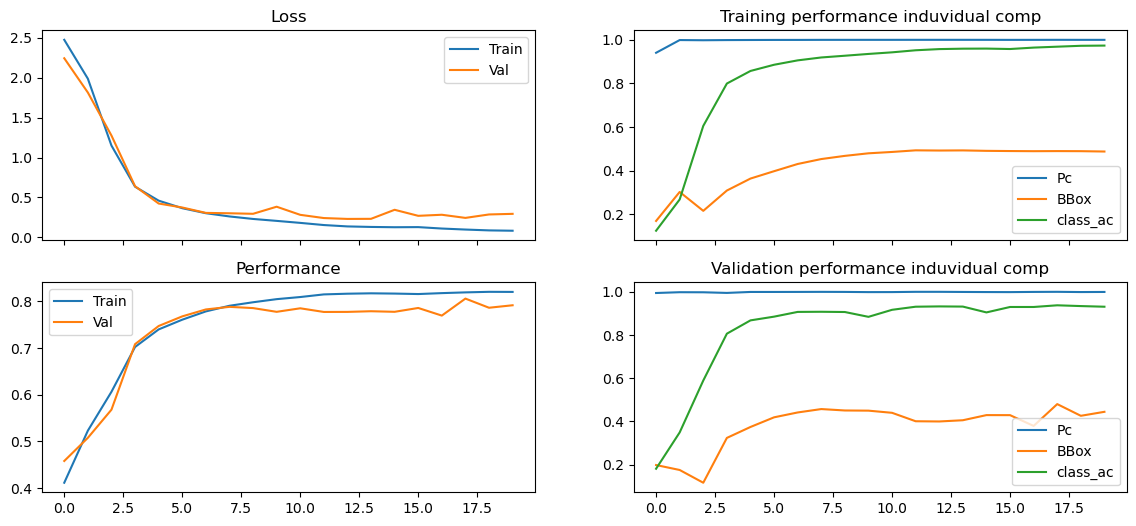

Best epoch for iou: 17 
score: 0.480 

Best epoch for accuracies: 17 
score: 0.969 % 

Best epoch in total: 17 
score: 0.806 

Latest epoch total score: 0.792 

-------------------------------------------------------------------------------------------------------------------------------------


-------------------------------------------------------------------------------------------------------------------------------------
CNN3_bn 



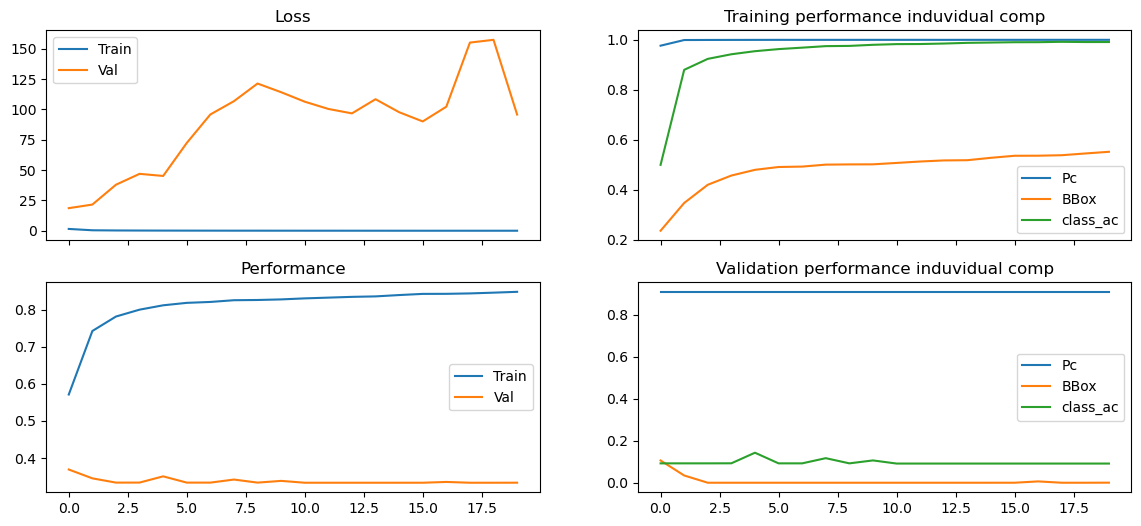

Best epoch for iou: 0 
score: 0.106 

Best epoch for accuracies: 4 
score: 0.526 % 

Best epoch in total: 0 
score: 0.369 

Latest epoch total score: 0.334 

-------------------------------------------------------------------------------------------------------------------------------------


-------------------------------------------------------------------------------------------------------------------------------------
CNN4 



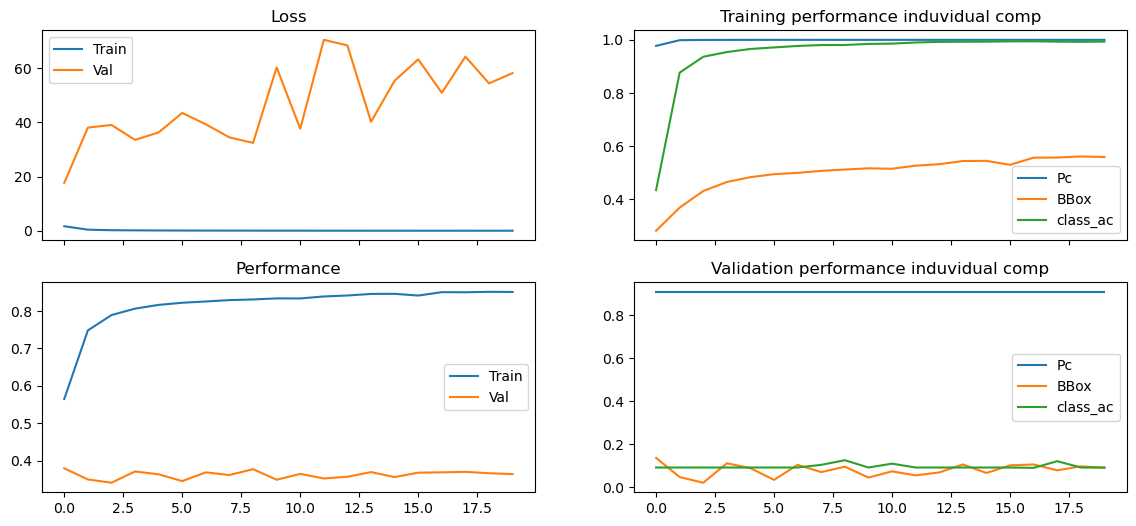

Best epoch for iou: 0 
score: 0.137 

Best epoch for accuracies: 8 
score: 0.518 % 

Best epoch in total: 0 
score: 0.379 

Latest epoch total score: 0.364 

-------------------------------------------------------------------------------------------------------------------------------------


-------------------------------------------------------------------------------------------------------------------------------------
ResNet 



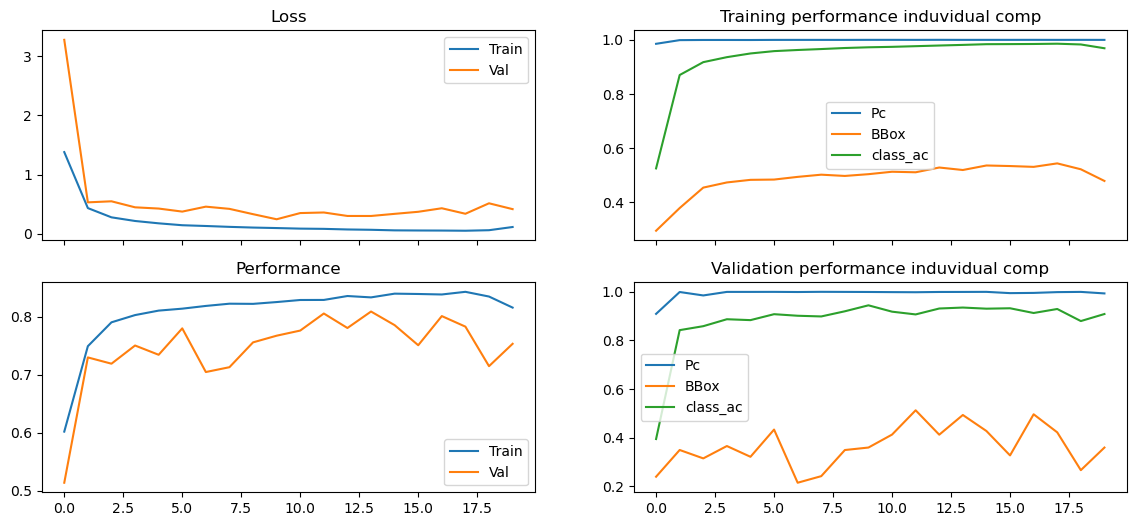

Best epoch for iou: 11 
score: 0.512 

Best epoch for accuracies: 9 
score: 0.972 % 

Best epoch in total: 13 
score: 0.809 

Latest epoch total score: 0.753 

-------------------------------------------------------------------------------------------------------------------------------------

The best model is: ResNet 
With 0.809 on validation data


In [93]:
#Important variables
best_model_info = None
best_score = 0
best_epoch = 0

#For every model. Print the results and check if it is better than the previous models
for model in models_results:
    print('\n-------------------------------------------------------------------------------------------------------------------------------------')
    print(model[0],'\n')
    model_val_results = torch.stack(model[1][3])
    
    accuracies = model_val_results[:,::2]
    ious = model_val_results[:,1]
    total_mean = model_val_results.mean(dim=1)
    best_mean = total_mean.argmax()
    best_model_score = total_mean[best_mean]

    plot_results(model[1])

    print('Best epoch for iou:', ious.argmax().item(), '\nscore:', f'{ious[ious.argmax()].item() :.3f}','\n')
    print('Best epoch for accuracies:', accuracies.mean(dim=1).argmax().item(), '\nscore:', f'{accuracies[accuracies.mean(dim=1).argmax()].mean().item() :.3f} %' ,'\n')
    print('Best epoch in total:', best_mean.item(), '\nscore:', f'{total_mean[best_mean].item() :.3f}','\n')
    print('Latest epoch total score:', f'{total_mean[-1].item() :.3f}','\n')
    
    if best_model_score > best_score:
        best_score = best_model_score
        best_model_info = model
        best_epoch= best_mean

    print('-------------------------------------------------------------------------------------------------------------------------------------\n')
    

print('The best model is:', model[0], '\nWith', f'{best_model_score.item() :.3f}', 'on validation data')


How ResNet trained


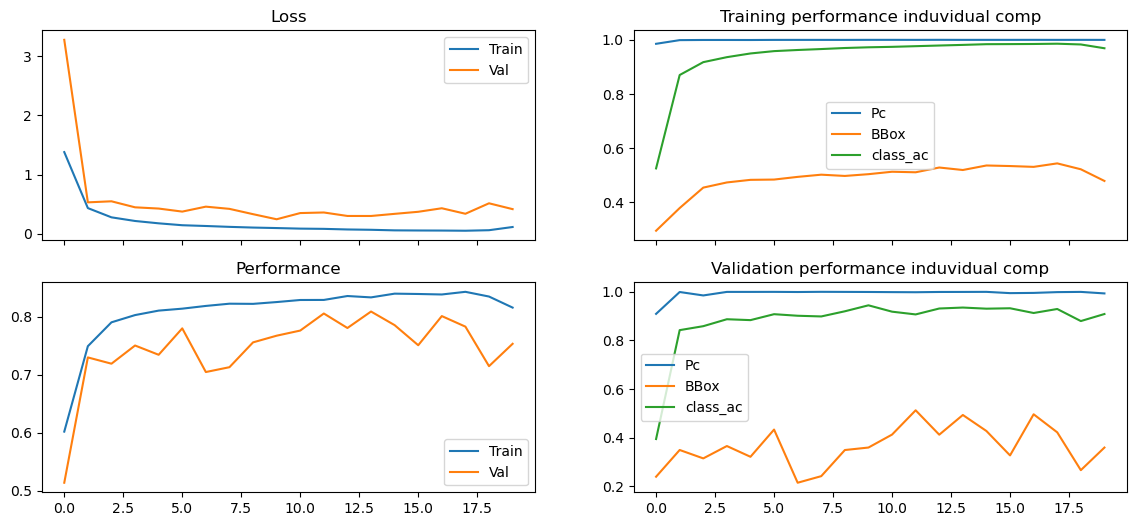

In [84]:
#Highlighting the best model
print(f'How {best_model_info[0]} trained')
plot_results(best_model_info[1])

In [91]:
#Testing with test data

model = best_model_info[2]
model.eval()

test_loader = DataLoader(localization_test_t, 512)

Want to use the best verison of model, and did not implement early stopping. So we are going to retrain the best model.

In [103]:
#Getting the model names
for c in range(0, len(models_results)):
    print(models_results[c][0]) 

CNN1
CNN2
CNN2_bn
CNN3
CNN3_bn
CNN4
ResNet


In [104]:
#A bit of an eye-sore. But is to ensures the same starting weights.
#Shouldve created a dictionary instead as we did later in task 3

if best_model_info[0] == 'CNN1':
    torch.manual_seed(seed)
    best_model = CNN1()
elif best_model_info[0] == 'CNN2':
    torch.manual_seed(seed)
    best_model = CNN2()
elif best_model_info[0] == 'CNN2_bn':
    torch.manual_seed(seed)
    best_model = CNN2_bn()
elif best_model_info[0] == 'CNN3':
    torch.manual_seed(seed)
    best_model = CNN3()
elif best_model_info[0] == 'CNN3_bn':
    torch.manual_seed(seed)
    best_model = CNN3_bn()
elif best_model_info[0] == 'CNN4':
    torch.manual_seed(seed)
    best_model = CNN4()
elif best_model_info[0] == 'ResNet':
    torch.manual_seed(seed)
    best_model = customResNet()

In [106]:
#The name of the best model
type(best_model).__name__

'ResNet'

In [111]:
#Re-training the best model, but stopping on the best epoch
torch.manual_seed(seed)
best_model = best_model.to(device)
optimizer = optim.Adam(best_model.parameters())
best_model_results = train(best_epoch, optimizer, best_model, train_loader, val_loader)


Epoch: 1, Train loss:  1.417, Train Performance: tensor([0.9854, 0.2879, 0.5051]): 100%|██████████| 233/233 [00:24<00:00,  9.33it/s]
Epoch: 2, Train loss:  0.435, Train Performance: tensor([0.9987, 0.3913, 0.8691]): 100%|██████████| 233/233 [00:24<00:00,  9.45it/s]
Epoch: 3, Train loss:  0.271, Train Performance: tensor([0.9993, 0.4487, 0.9189]): 100%|██████████| 233/233 [00:24<00:00,  9.44it/s]
Epoch: 4, Train loss:  0.219, Train Performance: tensor([0.9995, 0.4797, 0.9339]): 100%|██████████| 233/233 [00:24<00:00,  9.42it/s]
Epoch: 5, Train loss:  0.176, Train Performance: tensor([0.9996, 0.4861, 0.9478]): 100%|██████████| 233/233 [00:24<00:00,  9.54it/s]
Epoch: 6, Train loss:  0.147, Train Performance: tensor([0.9997, 0.4884, 0.9557]): 100%|██████████| 233/233 [00:24<00:00,  9.41it/s]
Epoch: 7, Train loss:  0.128, Train Performance: tensor([0.9997, 0.4967, 0.9610]): 100%|██████████| 233/233 [00:24<00:00,  9.50it/s]
Epoch: 8, Train loss:  0.113, Train Performance: tensor([0.9997, 0.50

In [140]:
#Now computing performance on all sets
best_model.eval()

train_performance=0
train_perf = 0
val_performance=0
val_perf = 0
test_performance=0
test_perf = 0

for imgs, labels in test_loader:
    with torch.no_grad():

        #Send the data to the same device
        imgs = imgs.to(device=device) 
        labels = labels.to(device=device)

        #Compute the inference of the images
        outputs = best_model(imgs)
        loss = custom_loss(outputs, labels)
        performance = performance_measuring(outputs, labels)

        test_perf += performance

for imgs, labels in val_loader:
    with torch.no_grad():

        #Send the data to the same device
        imgs = imgs.to(device=device) 
        labels = labels.to(device=device)

        #Compute the inference of the images
        outputs = best_model(imgs)
        loss = custom_loss(outputs, labels)
        performance = performance_measuring(outputs, labels)

        val_perf += performance

for imgs, labels in train_loader:
    with torch.no_grad():

        #Send the data to the same device
        imgs = imgs.to(device=device) 
        labels = labels.to(device=device)

        #Compute the inference of the images
        outputs = best_model(imgs)
        loss = custom_loss(outputs, labels)
        performance = performance_measuring(outputs, labels)

        train_perf += performance


test_performance = test_perf/len(test_loader)
val_performance = val_perf/len(val_loader)
train_performance = train_perf/len(train_loader)

In [147]:
#Printing the performance of the model
print('Performance on the last epoch:')

print('\nTrain mean accuracies:', f'{train_performance[::2].mean().item() :.3f} %','\n')
print('Train iou score:', f'{train_performance[1].item() :.3f}','\n')
print('Train mean score:', f'{train_performance.mean().item() :.3f}','\n')

print('\nVal mean accuracies:', f'{val_performance[::2].mean().item() :.3f} %','\n')
print('Val iou score:', f'{val_performance[1].item() :.3f}','\n')
print('Val mean score:', f'{val_performance.mean().item() :.3f}','\n')

print('\nTest mean accuracies:', f'{test_performance[::2].mean().item() :.3f} %','\n')
print('Test iou score:', f'{test_performance[1].item() :.3f}','\n')
print('Test mean score:', f'{test_performance.mean().item() :.3f}','\n')

Performance on the last epoch:

Train mean accuracies: 0.985 % 

Train iou score: 0.503 

Train mean score: 0.824 


Val mean accuracies: 0.968 % 

Val iou score: 0.506 

Val mean score: 0.814 


Test mean accuracies: 0.971 % 

Test iou score: 0.500 

Test mean score: 0.814 



Training
Performance: tensor([1.0000, 0.4842, 1.0000])


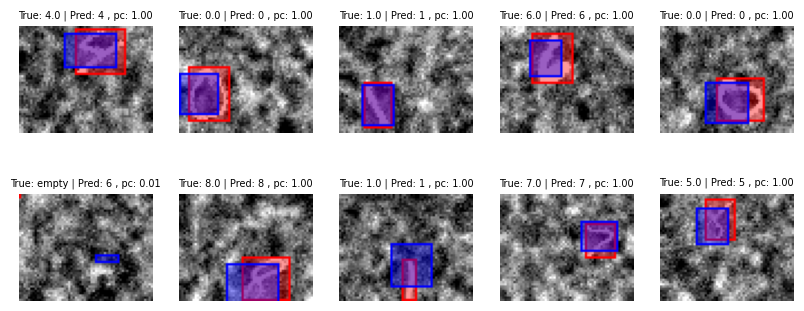

In [400]:
#Showing how it predicted with examples
print('Training')
show_pred_examples(best_model, localization_train_t, 10, show_data=localization_train)

Validation
Performance: tensor([1.0000, 0.4771, 1.0000])


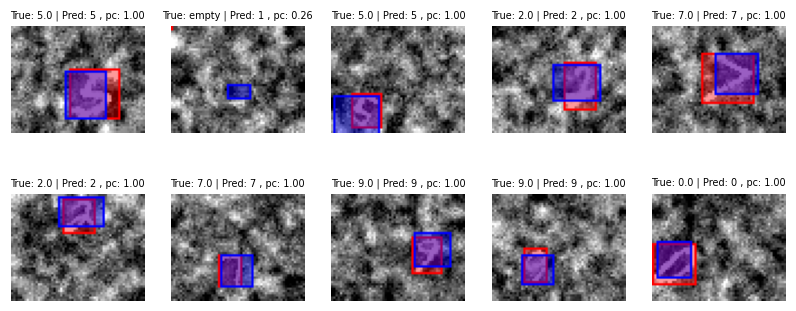

In [401]:
print('Validation')
show_pred_examples(best_model, localization_val_t, 10, show_data=localization_val)

Testing
Performance: tensor([1.0000, 0.4664, 0.8889])


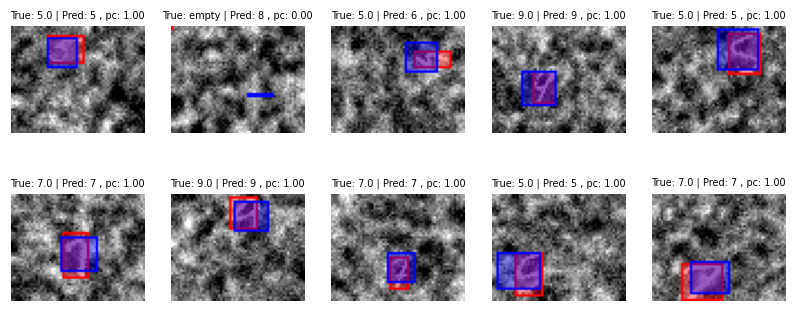

In [402]:
print('Testing')
show_pred_examples(best_model, localization_test_t, 10, show_data=localization_test)

### Why not identical results with retraining?
Explenation in report. Short answer is torch.use_deterministic_algorithms() and Adam optimizer

Practical demonstration below.

In [122]:
torch.manual_seed(seed)

model_test = CNN2().to(device)
optimizer = optim.SGD(model_test.parameters(), lr=0.001)
best_model_results = train(best_epoch, optimizer, model_test, train_loader, val_loader)

Epoch: 1:   0%|          | 0/233 [00:00<?, ?it/s]

Epoch: 1, Train loss:  3.076, Train Performance: tensor([9.0895e-01, 4.2047e-07, 9.8226e-02]): 100%|██████████| 233/233 [00:01<00:00, 145.61it/s]
Epoch: 2, Train loss:  2.803, Train Performance: tensor([0.9089, 0.0552, 0.0900]): 100%|██████████| 233/233 [00:01<00:00, 160.38it/s]
Epoch: 3, Train loss:  2.626, Train Performance: tensor([0.9089, 0.1280, 0.0920]): 100%|██████████| 233/233 [00:01<00:00, 168.32it/s]
Epoch: 4, Train loss:  2.604, Train Performance: tensor([0.9089, 0.1390, 0.1058]): 100%|██████████| 233/233 [00:01<00:00, 154.92it/s]
Epoch: 5, Train loss:  2.600, Train Performance: tensor([0.9089, 0.1478, 0.1553]): 100%|██████████| 233/233 [00:01<00:00, 166.12it/s]
Epoch: 6, Train loss:  2.598, Train Performance: tensor([0.9089, 0.1572, 0.1811]): 100%|██████████| 233/233 [00:01<00:00, 165.05it/s]
Epoch: 7, Train loss:  2.596, Train Performance: tensor([0.9089, 0.1672, 0.1877]): 100%|██████████| 233/233 [00:01<00:00, 162.96it/s]
Epoch: 8, Train loss:  2.593, Train Performance: t

In [123]:
torch.manual_seed(seed)

model_test = CNN2().to(device)
optimizer = optim.SGD(model_test.parameters(), lr=0.001)
best_model_results = train(best_epoch, optimizer, model_test, train_loader, val_loader)

Epoch: 1, Train loss:  3.076, Train Performance: tensor([9.0895e-01, 4.2048e-07, 9.8226e-02]): 100%|██████████| 233/233 [00:01<00:00, 149.61it/s]
Epoch: 2, Train loss:  2.803, Train Performance: tensor([0.9089, 0.0552, 0.0900]): 100%|██████████| 233/233 [00:01<00:00, 165.45it/s]
Epoch: 3, Train loss:  2.626, Train Performance: tensor([0.9089, 0.1280, 0.0920]): 100%|██████████| 233/233 [00:01<00:00, 173.34it/s]
Epoch: 4, Train loss:  2.604, Train Performance: tensor([0.9089, 0.1390, 0.1058]): 100%|██████████| 233/233 [00:01<00:00, 174.13it/s]
Epoch: 5, Train loss:  2.600, Train Performance: tensor([0.9089, 0.1478, 0.1552]): 100%|██████████| 233/233 [00:01<00:00, 167.68it/s]
Epoch: 6, Train loss:  2.598, Train Performance: tensor([0.9089, 0.1572, 0.1812]): 100%|██████████| 233/233 [00:01<00:00, 177.66it/s]
Epoch: 7, Train loss:  2.596, Train Performance: tensor([0.9089, 0.1672, 0.1878]): 100%|██████████| 233/233 [00:01<00:00, 177.76it/s]
Epoch: 8, Train loss:  2.593, Train Performance: t

In [124]:
torch.manual_seed(seed)

model_test = CNN2().to(device)
optimizer = optim.Adam(model_test.parameters(), lr=0.001)
best_model_results = train(best_epoch, optimizer, model_test, train_loader, val_loader)

Epoch: 1, Train loss:  2.340, Train Performance: tensor([0.9473, 0.3029, 0.1883]): 100%|██████████| 233/233 [00:01<00:00, 165.44it/s]
Epoch: 2, Train loss:  2.071, Train Performance: tensor([0.9851, 0.4231, 0.2388]): 100%|██████████| 233/233 [00:01<00:00, 169.33it/s]
Epoch: 3, Train loss:  1.938, Train Performance: tensor([0.9873, 0.4448, 0.3036]): 100%|██████████| 233/233 [00:01<00:00, 170.50it/s]
Epoch: 4, Train loss:  1.737, Train Performance: tensor([0.9914, 0.4426, 0.3912]): 100%|██████████| 233/233 [00:01<00:00, 170.09it/s]
Epoch: 5, Train loss:  1.487, Train Performance: tensor([0.9950, 0.4425, 0.4886]): 100%|██████████| 233/233 [00:01<00:00, 164.80it/s]
Epoch: 6, Train loss:  1.263, Train Performance: tensor([0.9971, 0.4521, 0.5709]): 100%|██████████| 233/233 [00:01<00:00, 171.81it/s]
Epoch: 7, Train loss:  1.084, Train Performance: tensor([0.9979, 0.4613, 0.6359]): 100%|██████████| 233/233 [00:01<00:00, 173.54it/s]
Epoch: 8, Train loss:  0.943, Train Performance: tensor([0.998

In [125]:
torch.manual_seed(seed)

model_test = CNN2().to(device)
optimizer = optim.Adam(model_test.parameters(), lr=0.001)
best_model_results = train(best_epoch, optimizer, model_test, train_loader, val_loader)

Epoch: 1, Train loss:  2.338, Train Performance: tensor([0.9480, 0.3124, 0.1883]): 100%|██████████| 233/233 [00:01<00:00, 166.19it/s]
Epoch: 2, Train loss:  2.071, Train Performance: tensor([0.9850, 0.4295, 0.2384]): 100%|██████████| 233/233 [00:01<00:00, 168.13it/s]
Epoch: 3, Train loss:  1.938, Train Performance: tensor([0.9871, 0.4427, 0.3049]): 100%|██████████| 233/233 [00:01<00:00, 169.21it/s]
Epoch: 4, Train loss:  1.731, Train Performance: tensor([0.9913, 0.4481, 0.3929]): 100%|██████████| 233/233 [00:01<00:00, 169.08it/s]
Epoch: 5, Train loss:  1.474, Train Performance: tensor([0.9951, 0.4383, 0.4925]): 100%|██████████| 233/233 [00:01<00:00, 162.39it/s]
Epoch: 6, Train loss:  1.253, Train Performance: tensor([0.9972, 0.4523, 0.5748]): 100%|██████████| 233/233 [00:01<00:00, 174.65it/s]
Epoch: 7, Train loss:  1.072, Train Performance: tensor([0.9979, 0.4584, 0.6398]): 100%|██████████| 233/233 [00:01<00:00, 171.92it/s]
Epoch: 8, Train loss:  0.926, Train Performance: tensor([0.998